# Exercise 3: PCA and Random Projections
### Due June 25 at 14:00

Please note: 

- Read the instructions in the exercise PDF and in this notebook carefully.
- Add your solutions *only* at `YOUR CODE HERE`/`YOUR ANSWER HERE` and remove the corresponding `raise NotImplementedError()`.
- Do not chance the provided code and text, if not stated.
- Do not *add* or *delete* cells.
- Do not `import` additional functionality. 
- Before submitting: Please make sure, that your notebook can be executed from top to bottom `Menu -> Kernel -> Restart & Run all`. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.testing import assert_equal, assert_almost_equal
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA

In [2]:
# load the USPS dataset
usps_df = pd.read_csv('USPS.csv', sep='\t',)
xs_usps = usps_df.drop(['Label'], axis=1).values
ys_usps = usps_df['Label'].values

xs_usps.shape, ys_usps.shape

((1000, 256), (1000,))

#### Here you can implement PCA and Random Projections yourself. This will be awarded with 1.5 bonus points per method. If you decide to do so, you have to use your implementation in this exercise. If you do not want to implement this, simply remove the NotImplementedError().

In [13]:
pca = PCA(n_components=2)
pca.fit(xs_usps)

grp = GaussianRandomProjection(n_components=2)
grp.fit(xs_usps)

GaussianRandomProjection(eps=0.1, n_components=2, random_state=None)

### (a) Reduce the dataset's dimensionality to d=2

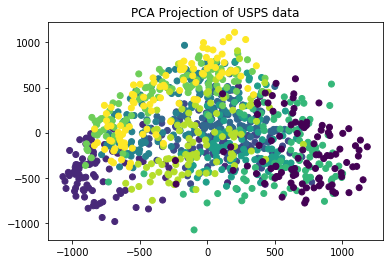

In [6]:
xs_usps_pca = pca.transform(xs_usps) # an np.array of shape 1000x2

plt.scatter(*xs_usps_pca.T, c=ys_usps)
plt.title('PCA Projection of USPS data')
plt.show()

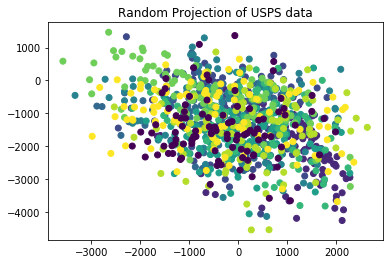

In [14]:
xs_usps_random = grp.transform(xs_usps)

plt.scatter(*xs_usps_random.T, c=ys_usps)
plt.title('Random Projection of USPS data')
plt.show()

### (b) Visualize prinicipal components and random directions

(2, 256)


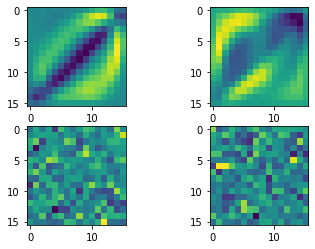

In [21]:
fig, axis = plt.subplots(2, 2)

pca_comp = pca.components_
grp_comp = grp.components_

print(pca_comp.shape)
axis[0,0].imshow(pca_comp[0].reshape(16,16))
axis[0,1].imshow(pca_comp[1].reshape(16,16))

axis[1,0].imshow(grp_comp[0].reshape(16,16))
axis[1,1].imshow(grp_comp[1].reshape(16,16))

plt.show()

### (c) Reconstruct a random projection

In [54]:
def reconstruct(xs_original, xs_projected):
    ''' Returns: A np.array of the same shape as xs_original
    '''
    #U = ((WX)^T * WX)^-1 (WX)^T Y
    #Like solution of least sqaures
    a = xs_projected.T @ xs_projected
    b = xs_projected.T @ xs_original
    U = np.linalg.solve(a, b)
    x_hat = xs_projected @ U
    
    return x_hat

In [55]:
np.random.seed(42)
W = np.random.normal(size=(256,2))/np.sqrt(2)
xs_reconstructed = reconstruct(xs_usps, xs_usps @ W)
assert_almost_equal(np.linalg.norm(xs_reconstructed), 28102.566390212647)

### (d) Visualize reconstructed images in feature space

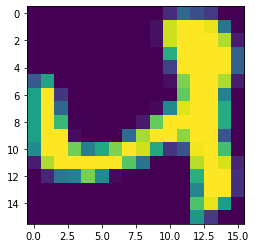

In [22]:
# we want to reconstruct digit number 100 - visualize it
digit = xs_usps[100,:]
plt.imshow(digit.reshape(16, 16))
plt.show()

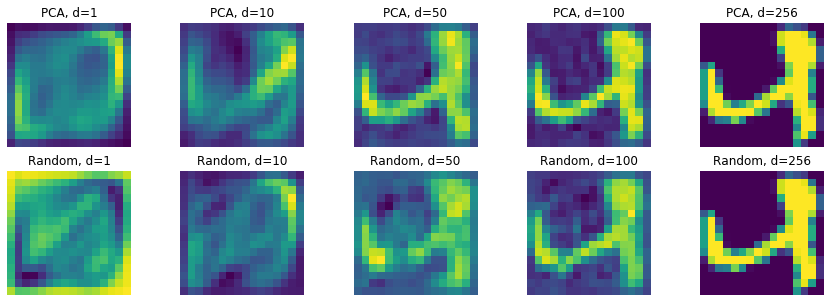

In [70]:
dimensions = [1, 10, 50, 100, 256]
fig, axis = plt.subplots(2, 5, figsize=(15,5))

for idx, dim in enumerate(dimensions):
    pca = PCA(n_components=dim)
    pca.fit(xs_usps)
    d = pca.transform(np.expand_dims(xs_usps[100], axis=0))
    inv = pca.inverse_transform(d)
    axis[0, idx].imshow(inv.reshape(16, 16))
    
    grp = GaussianRandomProjection(n_components=dim)
    grp.fit(xs_usps)
    
    xs_usps_grp = grp.transform(xs_usps)
    fe = xs_usps
    df = xs_usps_grp
    inv2 = reconstruct(fe, df)
    
    axis[1, idx].imshow(inv2[100].reshape(16, 16))
    axis[0, idx].set_title(f'PCA, d={dim}')
    axis[0, idx].axis('off')
    axis[1, idx].set_title(f'Random, d={dim}')
    axis[1, idx].axis('off')

plt.show()

### (e) Reconstruction Error of PCA and Random Projections

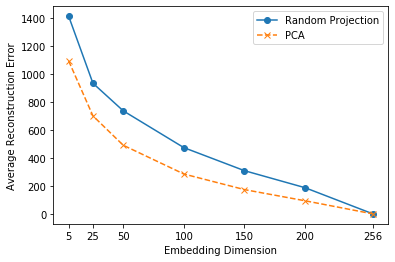

In [77]:
dimensions = [5, 25, 50, 100, 150, 200, 256]

errors_pca = np.zeros(len(dimensions)) 
errors_random = np.zeros(len(dimensions)) 

for idx, dim in enumerate(dimensions):
    pca = PCA(n_components=dim)
    pca.fit(xs_usps)
    d = pca.transform(xs_usps)
    inv = pca.inverse_transform(d)
    
    e = np.diag(euclidean_distances(xs_usps, inv))
    e = np.mean(e)
    errors_pca[idx] = e
    
    grp = GaussianRandomProjection(n_components=dim)
    grp.fit(xs_usps)
    xs_usps_grp = grp.transform(xs_usps)
    inv2 = reconstruct(xs_usps, xs_usps_grp)

    e = np.diag(euclidean_distances(xs_usps, inv2))
    e = np.mean(e)
    errors_random[idx] = e



plt.plot(dimensions, errors_random, 'o-', label='Random Projection')
plt.plot(dimensions, errors_pca, 'x--', label='PCA')
plt.xlabel('Embedding Dimension')
plt.xticks(dimensions)
plt.ylabel('Average Reconstruction Error')
plt.legend(loc='best')
plt.show()

### (f) Average and maximum distortion of distances

In [113]:
def pairwise_distortions(xs_orig, xs_new):
    a = euclidean_distances(xs_orig)
    b = euclidean_distances(xs_new)
    a_ind = np.triu_indices(a.shape[0], k=1)
    c = a[a_ind]/b[a_ind]
    d = b[a_ind]/a[a_ind]
    res = np.maximum(c,d)
    
    return res

def average_distortion(xs_orig, xs_new):
    return pairwise_distortions(xs_orig, xs_new).mean()
    
def maximum_distortion(xs_orig, xs_new):
    return pairwise_distortions(xs_orig, xs_new).max()

In [114]:
xs_orig = np.arange(10).reshape(-1, 1)
xs_new = xs_orig * xs_orig

assert_almost_equal(average_distortion(xs_orig, xs_orig), 1.)
assert_almost_equal(maximum_distortion(xs_new, xs_new), 1.)
assert_almost_equal(average_distortion(xs_orig, xs_new), 9.)
assert_almost_equal(maximum_distortion(xs_orig, xs_new), 17.)

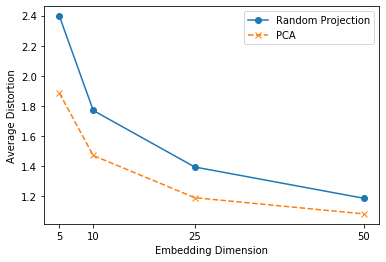

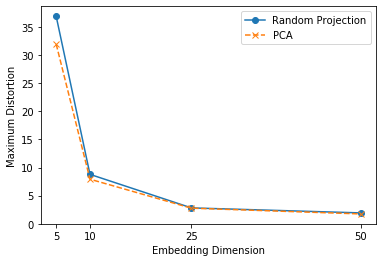

In [117]:
dimensions = [5, 10, 25,  50]

avg_distortion_pca = np.zeros(len(dimensions)) 
avg_distortion_random = np.zeros(len(dimensions)) 

for idx, dim in enumerate(dimensions):
    pca = PCA(n_components=dim)
    pca.fit(xs_usps)
    d = pca.transform(xs_usps)
    inv = pca.inverse_transform(d)
    
    avg_distortion_pca[idx] = average_distortion(xs_usps, inv)
    
    grp = GaussianRandomProjection(n_components=dim)
    grp.fit(xs_usps)
    xs_usps_grp = grp.transform(xs_usps)
    inv2 = reconstruct(xs_usps, xs_usps_grp)
    
    avg_distortion_random[idx] = average_distortion(xs_usps, inv2)


plt.plot(dimensions, avg_distortion_random, 'o-', label='Random Projection')
plt.plot(dimensions, avg_distortion_pca, 'x--', label='PCA')
plt.xlabel('Embedding Dimension')
plt.xticks(dimensions)
plt.ylabel('Average Distortion')
plt.legend(loc='best')
plt.show()

max_distortion_pca = np.zeros(len(dimensions)) 
max_distortion_random = np.zeros(len(dimensions)) 

for idx, dim in enumerate(dimensions):
    pca = PCA(n_components=dim)
    pca.fit(xs_usps)
    d = pca.transform(xs_usps)
    inv = pca.inverse_transform(d)
    
    max_distortion_pca[idx] = maximum_distortion(xs_usps, inv)
    
    grp = GaussianRandomProjection(n_components=dim)
    grp.fit(xs_usps)
    xs_usps_grp = grp.transform(xs_usps)
    inv2 = reconstruct(xs_usps, xs_usps_grp)
    
    max_distortion_random[idx] = maximum_distortion(xs_usps, inv2)

plt.plot(dimensions, max_distortion_random, 'o-', label='Random Projection')
plt.plot(dimensions, max_distortion_pca, 'x--', label='PCA')
plt.xlabel('Embedding Dimension')
plt.xticks(dimensions)
plt.ylabel('Maximum Distortion')
plt.legend(loc='best')
plt.show()


### (g) Summarize the advantages and disadvantages of PCA and Random Projections

Disadvantage of Random Projection can be that we lose more information than neccessary because we are not maximising variance per direction.
From the plots we could not see any advantage of Random Projections. PCA outperformed it on all metrics.
In theory random projections give guarantees over individual points which PCA does not give.